<center><img src='../../img/ai4eo_logos.jpg' alt='Logos AI4EO MOOC' width='80%'></img></center>

<hr>

<br>

<a href="https://www.futurelearn.com/courses/artificial-intelligence-for-earth-monitoring/1/steps/1212878"><< Back to FutureLearn</a><br>

# Global cloud classification with CUMULO

<i>by Valentina Zantendeschi, INRIA and University College London</i>

<hr>

## Watch the video tutorial

In [1]:
from IPython.display import HTML
HTML('<div align="center"><iframe src="https://player.vimeo.com/video/631909930?h=c149fd6c17" width="640" height="360" frameborder="0" allow="autoplay; fullscreen; picture-in-picture" allowfullscreen align="middle"></iframe></div>')     

<br>

<hr>

## Introduction

Modelling clouds and understanding their interactions with the climate system is one of the key problems for reducing uncertainty in future climate projections. An important first step in reducing this uncertainty is to accurately classify cloud types at high spatial and temporal resolution.

In this workflow, we are going to train a Machine Learning model (`Gradient Boosting of Decision Trees`) for classifying clouds into one of the eight [World Meteorological Organization (WMO) genera](https://cloudatlas.wmo.int/en/clouds-genera.html).

This workflow makes use of [CUMULO](https://github.com/FrontierDevelopmentLab/CUMULO), a dataset that provides **hyperspectral satellite images** at global scale and **cloud labels** for a subset of pixels (only along the track of the satellite).  

## Machine Learning algorithm

This workflow makes use of [LightGBM](https://lightgbm.readthedocs.io/en/latest/index.html), a gradient boosting framework that uses ensembles of tree-based learning algorithms. We choose this approach as it is computationally efficient and it provides models with high accuracy.

Given the small number of labels, we train a model at a pixel level and subsample data (**tiles**) in the labelled region.
More precisely, we use the `LightGBM` framework to build a set of decision trees and combine their predictions to fit the problem. This is done by iteratively updating the current model by minimizing the chosen objective function (the average loss on the training sample). At each iteration, `LightGBM` grows decision trees leaf-wise: it chooses the leaf with the maximal loss improvement and adds children nodes to it, and so on.

## Data

[CUMULO](https://github.com/FrontierDevelopmentLab/CUMULO) is a benchmark dataset for training and evaluating global cloud classification models. It merges two satellite products from [NASA's A-train constellation](https://atrain.nasa.gov/): the [Moderate Resolution Imaging Spectroradiometer (MODIS)](https://modis.gsfc.nasa.gov/about/) onboard the Aqua satellite and the [2B-CLDCLASS-LIDAR product](http://www.cloudsat.cira.colostate.edu/data-products/level-2b/2b-cldclass-lidar) derived from the combination of CloudSat Cloud Profiling Radar (CPR) and CALIPSO Cloud‐Aerosol Lidar with Orthogonal Polarization (CALIOP).

* #### MODIS products
MODIS products are hyperspectral images (**swaths**) of size 1354 x 2030 pixels saved at a spatial resolution of 1km by 1km. 
The MODIS detector measures 36 spectral bands (**channels**) between 620 and 14385 nm. Different _cloud properties_ can then be inferred from these channels (e.g. Cloud Temperature or Clouds Top Height), but no cloud labels are available. 

* #### 2B-CLDCLASS-LIDAR product
2B-CLDCLASS-LIDAR provides _cloud labels_ corresponding to the eight World Meteorological Organization (WMO) genera and other useful vertical information. These annotations are derived considering known properties of the WMO cloud types and thanks to the additional instruments. Nevertheless, they are not provided everywhere, but only on pixel-width (1km x 1km) ‘tracks’ of the satellites, with a revisit period of 16 days (no global coverage at 1km resolution is available even after 16 days).

<br>

Here is an example of one swath: its visible band (left) and its cloud mask (right) with its overlying label mask (the colored pixels in the vertical track).
<img src="figures/one-swath1.png" width=60%>

CUMULO brings these complementary datasets together, collocating CloudSat and MODIS-Aqua products. It contains over 300k annotated multispectral images at 1km by 1km resolution, providing daily full coverage of the Earth for 2008, 2009 and 2016. CUMULO data is available in netCDF.

The cloud layer types are classified as follows:
* `0 - Cirrus` 
* `1 - Altostratus`
* `2 - Altocumulus` 
* `3 - Stratus` 
* `4 - Stratocumulus` 
* `5 - Cumulus` 
* `6 - Nimbostratus` 
* `7 - Deep Convection` 

## Further resources

* [CUMULO Github repository](https://github.com/FrontierDevelopmentLab/CUMULO)
* [CUMULO: A Dataset for Learning Cloud Classification](https://arxiv.org/abs/1911.04227)
* [LightGBM - Gradient Boosting Framework by Microsoft](https://lightgbm.readthedocs.io/en/latest/index.html)

<hr>

## Notebook outline


* [1 - Data preparation](#data_preparation_6c)
* [2 - Data loading](#data_loading_6c)
* [3 - Define and train a LightLBM model](#model_setup_6c)
* [4 - Predict cloud classes with the trained lightGBM model](#predict_6c)
* [5 - Evaluate the model performance](#model_evaluation_6c)



<hr>

#### Import libraries

In [4]:
import netCDF4 as nc4
import numpy as np

from pathlib import Path
from tqdm import tqdm

import os
import sys
import glob
sys.path.append("src/")
from nc_tile_extractor import extract_cloudy_labelled_tiles
import zipfile
import lightgbm as lgb
from loader import CumuloDataset

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

import warnings
warnings.filterwarnings("ignore")

#### <a id='read_nc'></a>Helper function

In [2]:
def read_nc(nc_file):
    """return masked arrays, with masks indicating the invalid values"""
    
    file = nc4.Dataset(nc_file, 'r', format='NETCDF4')
    
    f_radiances = np.vstack([file.variables[name][:] for name in radiances])
    f_properties = np.vstack([file.variables[name][:] for name in properties])
    f_rois = file.variables[rois][:]
    f_labels = file.variables[labels][:]
    f_lats = file.variables[coordinates[0]][:]
    f_longs = file.variables[coordinates[1]][:]
    
    file.close()

    return f_radiances, f_properties, f_rois, f_labels, f_lats, f_longs

<hr>

<br>

## <a id='data_preparation_6c'></a>1. Data preparation

**Note**: This workflow makes use of the [CUMULO](https://www.dropbox.com/sh/6gca7f0mb3b0ikz/AADq2lk4u7k961Qa31FwIDEpa?dl=0) benchmark dataset. A subset of the benchmark dataset required for this workflow is already available in the folder `./DATA/nc/`. If you want to reproduce the example on your local machine, you can download and the data subset with the following command:
> curl -L -o month_1_day_18.zip https://www.dropbox.com/sh/6gca7f0mb3b0ikz/AABdbAzfbcCpwEPHbp9zBqWKa/CUMULO/2008/01/018/daylight?dl=1


In a following step, you can unzip the downloaded `.zip` folder with the following command:

<br>

The subset of the CUMULO benchmark dataset consists of 150 files in the `NetCDF` format, following the [CF convention](http://cfconventions.org/Data/cf-conventions/cf-conventions-1.7/cf-conventions.html).

There is one NetCDF per swath, one every 5 minutes and at a spatial resolution of 1km by 1km:

* **filename** =  AYYYYDDD.HHMM.nc
          
with 
* `YYYY` = year
* `DDD` = absolute day since 01.01.2008 
* `HH` = hour of day
* `MM` = minutes

The data files are valid for 18 January 2008. Let us open one file and inspect its content. You can open a `netCDF` file with the `Dataset()` constructor of the `netCDF4` library. You can see that each file contains 31 variables.

In [5]:
nc_dir = "DATA/nc/"
nc_files = glob.glob(nc_dir+"*.nc")
file = nc4.Dataset(nc_files[0], 'r', format='NETCDF4')
file

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    history: Created 04/11/19
    references: Source code: https://github.com/FrontierDevelopmentLab/CUMULO
    status_flag_meanings: Mark the availability of the variables, as certain variables can be measured only at daytime and products can temporarily fail. Possible values 
 daylight -- all radiance variables are complete (filled by nearest point (in time and space) interpolation if required) 
 night -- radiance variables EV_250_Aggr1km_RefSB_1, EV_250_Aggr1km_RefSB_2 and EV_1KM_RefSB_26 are incomplet 
 corrupt -- several radiance variables present missing values that could not be interpolated.
    title: CUMULO
    comment: A benchmark dataset for training and evaluating global cloud classification models. It merges two satellite products from the A-train constellation (https://atrain.nasa.gov/): the Moderate Resolution Imaging Spectroradiometer (MODIS) from Aqua satellite (https://modis.gsfc.nas

<br>

CUMULO provides different types of features (**channels**) per georeferenced grid-point. We make use of:
* `13 calibrated radiances` as input channels, as they capture the physical properties needed for cloud classification
* the available `labels` as groundtruth (one label per tile)
* the `cloud_mask` to select which grid-points to analyze (only the cloudy ones) 
* `cloud properties` for physically validating our model. These channels are derived from the raw radiances and provide higher level properties of a cloud, such as its top pressure, temperature, etc.

Here is the list of variables we are interested in:

In [26]:
coordinates = ['latitude', 'longitude']
radiances = ['ev_250_aggr1km_refsb_1', 'ev_250_aggr1km_refsb_2', 'ev_1km_emissive_29', 'ev_1km_emissive_33', 'ev_1km_emissive_34', 'ev_1km_emissive_35', 'ev_1km_emissive_36', 'ev_1km_refsb_26', 'ev_1km_emissive_27', 'ev_1km_emissive_20', 'ev_1km_emissive_21', 'ev_1km_emissive_22', 'ev_1km_emissive_23']
properties = ['cloud_water_path', 'cloud_optical_thickness', 'cloud_effective_radius', 'cloud_phase_optical_properties', 'cloud_top_pressure', 'cloud_top_height', 'cloud_top_temperature', 'cloud_emissivity', 'surface_temperature']
rois = 'cloud_mask'
labels = 'cloud_layer_type'

<br>

The next step is to extract from each file tiles with a `3x3 pixel window size`. These tiles will be used as input to the Machine Learning model. The `3x3 pixel tiles` are sampled around each labelled pixel of an image. Thus, tiles might overlap. The tiles shall be stored in the `.npz` format, which is a zipped archive of files, of which each contains one variable in the `.npy` format.

In [27]:
nc_dir = Path("DATA/nc/")

# make directory where tiles will be stored
save_dir = Path("DATA/npz/")
save_dir.mkdir(parents=True, exist_ok=True)

# retrieve all files in netcdf format
nc_paths = nc_dir.glob("*.nc")

<br>

Now, let us go over each netCDF file, and execute the following operations:
1. extract the required variables from the netCDF file with the helper function [read_nc()](#read_nc). The function loads a netCDF file and returns four masked arrays with the required `radiances`, `properties`, `cloud_mask` and `cloud_labels`.
2. apply the function `extract_cloudy_labelled_tiles`, which extracts all tiles from a cloud area that are labelled. 
3. save the tile-based `radiances`, `properties`, `cloud_mask`, `cloud_labels` and `location` as uncompressed `.npz` file

The `.npz` files are stored under `./DATA/npz/`.


In [28]:
for filename in tqdm(nc_paths):
    
    # load swath variables and label masks
    f_radiances, f_properties, f_cloud_mask, f_labels, *_ = read_nc(filename)
    
    # labelled pixels have at least one non-zero value over the vertical axis
    f_label_mask = np.sum(~f_labels.mask, 3) > 0
    
    # for the purposes of this tutorial, we are going to extract only labelled tiles
    try:
        labelled_tiles, labelled_positions = extract_cloudy_labelled_tiles((f_radiances, f_properties, f_cloud_mask, f_labels), f_cloud_mask[0], f_label_mask[0])
        
        name = os.path.basename(filename).replace(".nc", ".npz")

        np.savez_compressed(save_dir / name, 
                            radiances=labelled_tiles[0].data, 
                            properties=labelled_tiles[1].data, 
                            cloud_mask=labelled_tiles[2].data, 
                            labels=labelled_tiles[3].data, 
                            location=labelled_positions)
    
    except:
        pass

159it [06:02,  2.28s/it]


<br>

## <a id='data_loading_6c'></a>2. Data loading

The next step is to load the data for learning the ML cloud classifier. `CumuloDataset()` is a constructor which loads the tiles that we have just extracted. When called, it returns the radiance channels that we use as inputs and the labels that we use as outputs for the `LightLBM` model.

As one tile can have multiple labels, `CumuloDataset()` returns only the most frequent one.
It requires as arguments:
* `root_dir`: the directory where the tiles are stored 
* `ext`: the extension/format of the files containing the tiles that are going to be read (npz in our case)

In [7]:
dataset = CumuloDataset(root_dir='DATA/npz/', ext="npz")


<br>

Afterwards, we want to load all tiles at once and vectorize them, as required by the `LightGBM` model. The result are the following vectorized tiles:
* `X` - Radiances as input for the model
* `y` - cloud labels as output for the model
* `p` - Physical properties which are used later to evaluate the outcomes also on a physical level

In [8]:
xs, ys, props = [], [], []

for filename, radiances, properties, cloud_mask, labels in dataset:
    xs.append(radiances) # radiances
    ys.append(labels) # labels
    props.append(properties) # we load also the physical properties and use them later on for physical evaluation

shape = xs[0].shape
X = np.vstack(xs).reshape(-1, shape[1] * shape[2] * shape[3]) # vectorize tiles
y = np.hstack(ys)

shape = props[0].shape
p = np.vstack(props).reshape(-1, shape[1] * shape[2] * shape[3]) # vectorize tiles

<br>

In total, 63945 tiles were loaded and the shapes of the `input`, `output` and `properties` are the following:

In [9]:
X.shape, y.shape, p.shape

((63945, 117), (63945,), (63945, 81))

<br>

Now, we can split the input and output variables into subsets for `training`, `validation` and `testing`:
* `training data`: is the actual sample used to train the Machine Learning model
* `validation data`: used to evaluate a model during training, but the model does not learn from this data
* `test data`: used to provide an evaluation of the final model and it is only used when a model is completely trained

It is important to define such sets in order to have a correct evaluation of the model performance and to ensure that the model not just simply memorizes its training data.

[scikit-learn](https://scikit-learn.org/stable/) offers a function called `train_test_split()` which congruently splits the arrays into two.

The function takes the following keyword arguments (kwargs):
* `arrays`: input, output data arrays
* `test_size`: a float number representing the proportion of the dataset to include in the test subset
* `random_state`: An integer assuring reproducibility of the random shuffling of the data  

The split resulted in the following subsets: `training: 46040 tiles`, `validation: 5116 tiles` and `testing: 12789 tiles`.

In [13]:
# we use 20% of data as test set
train_xs, test_xs, train_ys, test_ys = train_test_split(X, y, test_size=0.20, random_state=42)

# we use 10% of the remaining data for validation
train_xs, val_xs, train_ys, val_ys = train_test_split(train_xs, train_ys, test_size=0.10, random_state=42)

print(train_xs.shape, train_ys.shape, val_xs.shape, val_ys.shape, test_xs.shape, test_ys.shape)

(46040, 117) (46040,) (5116, 117) (5116,) (12789, 117) (12789,)


<br>

## <a id='model_setup_6c'></a>3. Define and train a LightGBM model

The next step is to load the `lightGBM` library and to convert the `training` and `validation` subsets into a `lightgbm.basic.Dataset`. You can do the conversion with the `Dataset` constructor of the `lightgbm` library. The constructor requires input and output subsets for the model.

In [14]:
lgb_train = lgb.Dataset(train_xs, train_ys)
lgb_valid = lgb.Dataset(val_xs, val_ys)

<br>

The next step is to specify a set of `hyperparameters`, with which a Machine Learning model can be fine-tuned. LightGBM offers several algorithms and the hyperparameters strongly affect the performance of the model.

Let us set the following parameters for the training process:

* `boosting_type`: *gbdt* for traditional Gradient Boosting Decision Tree (other algorithms are available too)
* `objective`: *multiclass* means we optimize a softmax-based loss over the classes
* `num_classes`: *8* as the number of cloud types we want to identify is eight
* `num_iterations`: *400* maximal number of iterations, where at each iteration a new decision tree per class is fit onto the problem
* `num_leaves`: maximal number of leaves of a tree
* `learning_rate`: *0.1* the step value for model update
* `verbose`: we set the verbosity level to *0* to print only errors and warnings

In [15]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_classes': 8,
    'num_iterations': 400,
    'num_leaves': 31,
    'learning_rate': 0.1,
    'verbose': 0,
}

<br>

The next step is to run the algorithm on the training data subset, based on the hyperparameters defined above. You can use the function `train()` from the `lightGBM` library. The functions takes the following keyword arguments:
* `params`: defined hyperparameters
* `dataset`: training data subset
* `valid_sets`: validation data subset

The validation dataset is used in order to select the best performing model based on the performance of this subset. 
Indeed, the best model is not necessarily the one obtained at the end of the training cycle, as it might have started to memorize the training set which would result in a bad performance during the inference/testing process.

In [16]:
gbm = lgb.train(params, lgb_train, valid_sets=[lgb_valid])

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	valid_0's multi_logloss: 1.39531
[2]	valid_0's multi_logloss: 1.27845
[3]	valid_0's multi_logloss: 1.19207
[4]	valid_0's multi_logloss: 1.11918
[5]	valid_0's multi_logloss: 1.06073
[6]	valid_0's multi_logloss: 1.01149
[7]	valid_0's multi_logloss: 0.969147
[8]	valid_0's multi_logloss: 0.934612
[9]	valid_0's multi_logloss: 0.904023
[10]	valid_0's multi_logloss: 0.87687
[11]	valid_0's multi_logloss: 0.852764
[12]	valid_0's multi_logloss: 0.832791
[13]	valid_0's multi_logloss: 0.814842
[14]	valid_0's multi_logloss: 0.798338
[15]	valid_0's multi_logloss: 0.7826
[16]	valid_0's multi_logloss: 0.769882
[17]	valid_0's multi_logloss: 0.757787
[18]	valid_0's multi_logloss: 0.746473
[19]	valid_0's multi_logloss: 0.73692
[20]	valid_0's multi_logloss: 0.727597
[21]	valid_0's multi_logloss: 0.719662
[22]	valid_0's multi_logloss: 0.711

<br>

## <a id='predict_6c'></a> 4. Predict cloud classes with the trained lightGBM model

Above, you can see that at about iteration 380 the model **overfits**. This means that the model starts to memorize the training set and its performance on unseen data (e.g. validation data) decreases. The model with the highest performance to make cloud class predictions is the one where the `validation loss` is lowest. The best model can be identified with `gbm.best_iteration`. 


Hence, you want to use the best model to make predictions on the `training`, `validation` and `test` data subsets. At a later stage, you can then evaluate the model's performance to predict the respective data subsets.

The function `gbm.predict()` allows you to predict cloud types based on the trained `lightGBM` model and the training, validation and test input data respectively.

In [17]:
train_prob_pred = gbm.predict(train_xs, num_iteration = gbm.best_iteration)
val_prob_pred = gbm.predict(val_xs, num_iteration = gbm.best_iteration)
test_prob_pred = gbm.predict(test_xs, num_iteration = gbm.best_iteration)

In [18]:
train_prob_pred.shape, val_prob_pred.shape, test_prob_pred.shape

((46040, 8), (5116, 8), (12789, 8))

<br>

The prediction process returns for each input tile a vector indicating the probability of each of the eight cloud classes. The predicted cloud class is hence the cloud type/class with the highest probability. You can select the maximum argument of a numpy array with the function `argmax()`.

In [19]:
train_y_pred = np.argmax(train_prob_pred, 1)
val_y_pred = np.argmax(val_prob_pred, 1)
test_y_pred = np.argmax(test_prob_pred, 1)

In [20]:
train_y_pred.shape, val_y_pred.shape, test_y_pred.shape

((46040,), (5116,), (12789,))

<br>

## <a id='model_evaluation_6c'></a>5. Model evaluation

An important step after the prediction process is to evaluate the predicted cloud classes. Let us start with creating and analysing the `confusion matrices` for the predictions based on `training`, `validation` and `test` input data. A confusion matrix is a common table layout that allows the visualisation of the performance of an algorithm.

Each component `c[i,j]` of a confusion matrix is equal to the ratio of tiles of class `i` that have been classified as class `j`.
This means that on the diagonal of the confusion matrix, we have the ratio of tiles that have been correctly classified, while on the rest of the matrix we see how often tiles of a target class are misclassified as belonging to another particular class. 

The built-in sklearn's function `confusion_matrix()` can be called to compute a confusion matrix, providing the following arguments:
- a vector of groundtruth classes
- a vector of the same size of predicted classes
- `labels`: the classes for which the scores are computed
- `normalize='true'` to return ratios instead of counts


In [21]:
train_cm = confusion_matrix(train_ys, train_y_pred, labels=range(8), normalize='true')
val_cm = confusion_matrix(val_ys, val_y_pred, labels=range(8), normalize='true')
test_cm = confusion_matrix(test_ys, test_y_pred, labels=range(8), normalize='true')

<br>

The next step is to visualize the three confusion matrices as `heatmap`. You can use the function `heatmap()` from the seaborn library to visualise a confusion matrix.

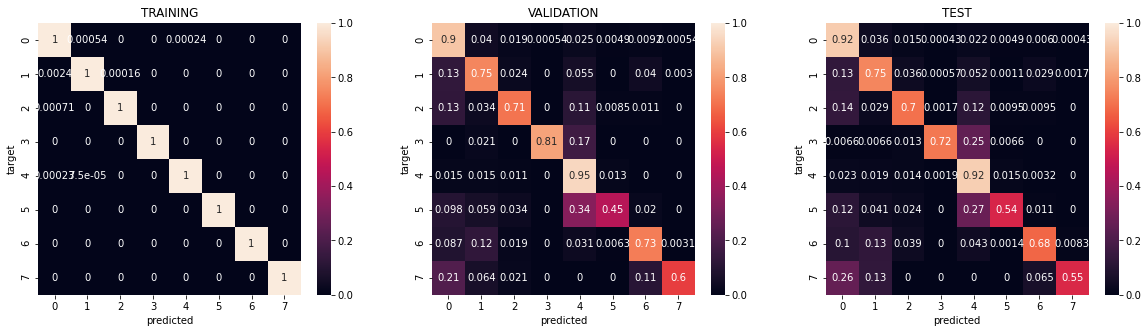

In [22]:
plt.figure(figsize = (20,5))

for i, (label, cm) in enumerate(zip(["TRAINING", "VALIDATION", "TEST"], [train_cm, val_cm, test_cm])):
    plt.subplot(131+i)

    df_cm = pd.DataFrame(cm, index=range(8), columns=range(8))

    plt.title(label)
    ax = sn.heatmap(df_cm, annot=True, vmin=0, vmax=1)
    ax.set(xlabel='predicted', ylabel='target')

<br>

The confusion matrices above show that the `LightGBM` was able to almost perfectly fit the training data. However on the validation and test data subsets, the predictability of the model is lower. In particular, the model shows good performance on class `0 - Cirrus`, while tiles of class `7 - Deep Convection` are often missclassified as class `0 - Cirrus` or `1 - Altostratus`.

Further, you can evaluate the perfomance of the model using two metrics that are standard for assessing the quality of Machine Learning classifiers:
- `accuracy`: the general rate of correctly classified tiles
- average `F1 score`: a metric that accounts for `model precision` (the ratio of true positives over all positives) and `recall` (the ratio of true positives over all tiles of that class) for each cloud type

You can use the the functions `accuracy_score()` and `f1_score()` from the scikit-learn library to calculate the two metrics. `F1 Score` can range from [0, 1], which 1 indicating perfect precision and recall. Thus, the higher the `F1 score` the better.

The accuracy score is around 0.84 and indicates that the model is 84% accurate.

In [23]:
accuracy = accuracy_score(test_ys, test_y_pred)
f1 = f1_score(test_ys, test_y_pred, average='macro')

print("Test accuracy:", accuracy)
print("Test f1 score:", f1)

Test accuracy: 0.8420517632340292
Test f1 score: 0.7633565206406072


<br>

<br>

<a href="https://www.futurelearn.com/courses/artificial-intelligence-for-earth-monitoring/1/steps/1212878"><< Back to FutureLearn</a><br>

<hr>

<img src='../../img/copernicus_logo.png' alt='Copernicus logo' align='left' width='20%'></img>

Course developed for [EUMETSAT](https://www.eumetsat.int/), [ECMWF](https://www.ecmwf.int/) and [Mercator Ocean International](https://www.mercator-ocean.fr/en/) in support of the [EU’s Copernicus Programme](https://www.copernicus.eu/en) and the [WEkEO platform](https://wekeo.eu/).
